In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
##import mpld3
##from mpld3 import plugins, utils
#mpld3.enable_notebook()

In [4]:
# 1. Create data structures (TODO: do not work with files?)

# Which examples belong to test set?

f = open('INDEX_core_data.2013','r')
testset = {}

for line in f:
    if not(line.startswith('#')): # skip info lines
        parts = line.split()
        id = parts[0]
        testset[id] = 1 # to know which examples belong to test set
f.close()

# Make ID file of example and keep index to know which examples are in training and test set

f = open('INDEX_refined_data.2015','r')
o1 = open('pdbbind2015_ids','w')

count = 0
index = {}
value = {}

for line in f:
    if not(line.startswith('#')): # skip info lines
        parts = line.split()
        id = parts[0]
        o1.write(id+'\n')
        val = parts[3]
        index[id] = count
        value[id] = val
        count += 1

f.close()
o1.close()

o2 = open('pdbbind2015.train','w')
o3 = open('pdbbind2015.test','w')

for k in index.keys():
    if k in testset.keys():
        o3.write(str(value[k])+' '+str(index[k])+'\n')
    else:
        o2.write(str(value[k])+' '+str(index[k])+'\n')

o2.close()
o3.close()

In [5]:
# For now I will dump the original data (>2.5GB) and keep only the parts we need in GitHub (20MB).

import os

directory = 'atomLigandFiles'

if not os.path.exists(directory):
    os.makedirs(directory)

directory = 'atomPocketFiles'

if not os.path.exists(directory):
    os.makedirs(directory)

directory = 'atomCombined'

if not os.path.exists(directory):
    os.makedirs(directory)


f = open('pdbbind2015_ids','r')
for line in f:
	id = line.rstrip('\n')

	combinedfile_out = open('atomCombined/'+id+'_combined.txt','w')

	# retrieve ligand and parse (MOL2 format)

	ligandfile = open('refined-2015/'+id+'/'+id+'_ligand.mol2','r')
	ligandfile_out = open('atomLigandFiles/'+id+'_ligand.txt','w')

	#for l in ligandfile:
        # 1 N         -27.4310  -20.9950  -15.7020 N.4       1 MLY         0.2327

	l = ligandfile.readline()	
	while (l != ''):
		if (l.startswith('@<TRIPOS>ATOM')):
			l = ligandfile.readline()
			while (not l.startswith('@<TRIPOS>BOND')):
				l = l.rstrip('\n')
				parts = l.split()
				# TODO: do extra check here to see if parts are valid? (check if 5th part is a letter for example?)
				xco = parts[2]
				yco = parts[3]
				zco = parts[4]
				atomtype_raw = parts[5]
				atomtype_parts = atomtype_raw.split('.')
				atomtype = atomtype_parts[0]
				ligandfile_out.write(xco+':'+yco+':'+zco+':'+atomtype+'\n')
				combinedfile_out.write(xco+':'+yco+':'+zco+':'+atomtype+':ligand\n')

				l = ligandfile.readline()
		
		l = ligandfile.readline()

	ligandfile.close()
	ligandfile_out.close()


	# retrieve protein and parse (PDB format)

	proteinfile = open('refined-2015/'+id+'/'+id+'_pocket.pdb','r')
	proteinfile_out = open('atomPocketFiles/'+id+'_pocket.txt','w')

	for al in proteinfile:
		if (al.startswith('ATOM')):
			al_list = list(al)
			xco = al_list[30:38]
			yco = al_list[38:46]
			zco = al_list[46:54]
			atomtype = al_list[76:78]
			xco = (''.join(xco)).strip()
			yco = (''.join(yco)).strip()
			zco = (''.join(zco)).strip()
			atomtype = (''.join(atomtype)).strip()
			proteinfile_out.write(xco+':'+yco+':'+zco+':'+atomtype+'\n')
			combinedfile_out.write(xco+':'+yco+':'+zco+':'+atomtype+':protein\n')
	proteinfile.close()
	proteinfile_out.close()

	combinedfile_out.close()


f.close()



In [6]:
import sys
import math

def extractXYZ(line):
	ar = line.split(":")[:3]
	return (float(ar[0]), float(ar[1]), float(ar[2]))
	
def distance(p1, p2):
	return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2
	
def addToAdjacency(id1, id2, adl):
	if id1 not in adl:
		adl[id1] = [id2]
	else:
		adl[id1].append(id2)
		
	if id2 not in adl:
		adl[id2] = [id1]
	else:
		adl[id2].append(id1)
		
def extractAdjacency(file, fileout, dist):
	f = open(file,'r')
	d = float(dist)**2
	lst = []
	# get all the atoms
	for line in f:
		lst.append(extractXYZ(line))
	f.close()
	
	adj = {}
	for id1 in range(len(lst)):
		for id2 in range(id1+1, len(lst)):
			p1 = lst[id1]
			p2 = lst[id2]
		
			if distance(p1,p2) < d:
				addToAdjacency(id1, id2, adj)

	f_out = open(fileout,'w')
	# print out the adjacency matrix
	for id1 in range(len(lst)):
		f_out.write(str(id1+1) + ":");
		if id1 in adj:
			for id2 in adj[id1]:
				f_out.write(str(id2+1)+",");
		f_out.write(":\n")
	f_out.close()
		
f = open('pdbbind2015_ids','r')
for line in f:
	id = line.rstrip('\n')

	dist = 4 # angstrom

	infile = 'atomCombined/'+id+'_combined.txt'
	outfile = 'atomCombined/'+id+'_adj'+str(dist)+'.txt'

	extractAdjacency(infile,outfile,dist)
f.close()

In [38]:
import networkx as nx

def load_interaction_graph(atom_file,adj_file):

    # make graph object
    graph = nx.Graph()
    graph.graph['id'] = id

    # process nodes

    count = 1

    atom_stream = open(atom_file,'r')

    for atom_line in atom_stream:
        atom_line = atom_line.rstrip('\n')
        parts = atom_line.split(':')
        xco = parts[0]
        yco = parts[1]
        zco = parts[2]
        atomtype = parts[3]
        origin = parts[4] # ligand or protein

        graph.add_node(count, label=atomtype, type=origin)

        count += 1

    atom_stream.close()

    # process edges
    # node ids start from 1 in adj files
    
    l = '1' # just put one for now as label

    adj_stream = open(adj_file,'r')
    for adj_line in adj_stream:
        parts = adj_line.split(':')
        kn1 = parts[0]
        neighbors = parts[1].split(',')
        for kn2 in neighbors:
            if (kn2 != ''):
                if (kn1 < kn2):
                    if graph.node[int(kn1)]['type'] != graph.node[int(kn2)]['type']: # they have a different type (ligand/protein)
                        graph.add_edge(kn1,kn2,label=l,nesting=True)
                    else:
                        graph.add_edge(kn1,kn2,label=l)
                else:
                    if graph.node[int(kn1)]['type'] != graph.node[int(kn2)]['type']: # they have a different type (ligand/protein)
                        graph.add_edge(kn2,kn1,label=l,nesting=True)
                    else:
                        graph.add_edge(kn2,kn1,label=l)

    adj_stream.close()

    return graph



f = open('pdbbind2015_ids_temp','r')
for line in f:
    id = line.rstrip('\n')

    dist = 4 # angstrom

    atom_file = 'atomCombined/'+id+'_combined.txt'
    adj_file = 'atomCombined/'+id+'_adj'+str(dist)+'.txt'


        
    graph = load_interaction_graph(atom_file,adj_file)
    
    #print graph.node[1]['type']
    
    #print 'Nb_nodes= '+str(len(graph.nodes()))
    #print 'Nb_edges= '+str(len(graph.edges()))

f.close()

Nb_nodes= 498
Nb_edges= 1725


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import os, sys
import networkx as nx
    
import logging
logger = logging.getLogger(__name__)


class ConvertProteinLigand(BaseEstimator, TransformerMixin):

    def fit(self):
        return self

    def transform(self, path=None):
        try:
            dirs = os.listdir(path)
            for file_name in dirs:
                if '.graph' in file_name:
                    graph = self.load_interaction_graph(os.path.join(path, file_name))
                    if graph.nodes():
                        yield graph
        except Exception as e:
            logger.debug('Failed iteration. Reason: %s' % e)
            logger.debug('Exception', exc_info=True)
    
    def _parse_protein_name(self, name):
        #interaction_data/interaction6840_5STD.graph
        tokens = name.split('.')
        # remove .graph
        name = tokens[0]
        # remove first part
        tokens = name.split('/')
        name = tokens[1]
        tokens = name.split('_')
        name = tokens[1]
        name = name.lower()
        return name
    
    def load_interaction_graph(self, file_name):
        trigger = False
        graph = nx.Graph()
        graph.graph['id'] = self._parse_protein_name(file_name)
        with open(file_name,'r') as f:
            for line in f:
                if line.startswith('VERTEX PROTEIN'):
                    #VERTEX PROTEIN 1 N N.4 LYS1
                    parts = line.split()
                    number = int(parts[2]) - 1
                    parts2 = parts[4].split('.')
                    l = ''+parts2[0]
                    graph.add_node(number, label=l, type='protein')
                elif line.startswith('VERTEX LIGAND'):
                    #VERTEX LIGAND 952 PB P.3 PAP125
                    parts = line.split()
                    number = int(parts[2]) - 1
                    parts2 = parts[4].split('.')
                    #l = '.'+parts2[0]
                    l = ''+parts2[0]
                    graph.add_node(number, label=l, type='ligand')
                elif line.startswith('EDGE PROTEIN'):
                    #EDGE PROTEIN 1 1 2 1
                    parts = line.split()
                    vertex1 = int(parts[3]) - 1
                    vertex2 = int(parts[4]) - 1
                    l = parts[5]
                    graph.add_edge(vertex1,vertex2, label=l)
                elif line.startswith('EDGE LIGAND'):
                    #EDGE LIGAND 972 952 953 ar
                    parts = line.split()
                    vertex1 = int(parts[3]) - 1
                    vertex2 = int(parts[4]) - 1
                    l = parts[5]
                    graph.add_edge(vertex1,vertex2, label=l)
                elif line.startswith('EDGE INTERACTION'):
                    #EDGE INTERACTION 1005 952 98 hi
                    parts = line.split()
                    vertex1 = int(parts[3]) - 1
                    vertex2 = int(parts[4]) - 1
                    l = parts[5]
                    graph.add_edge(vertex1,vertex2, label=l, nesting=True)
                    trigger = True
                else:
                    logger.error('Could not parse '+line)
            if trigger:
                return graph
            else:
                return nx.Graph()

In [16]:
from collections import defaultdict, deque
class MarkActive(BaseEstimator, TransformerMixin):

    """
    Missing.
    """

    def __init__(self, max_depth=10, attribute='active', key_nesting='nesting'):
        self.max_depth = max_depth
        self.attribute = attribute
        self.key_nesting = key_nesting

    def fit(self):
        return self

    def transform(self, graphs):
        """
        Todo.
        """
        try:
            for graph in graphs:
                marked_graph = self.mark_active(graph)
                yield marked_graph
        except Exception as e:
            logger.debug('Failed iteration. Reason: %s' % e)
            logger.debug('Exception', exc_info=True)

    def mark_active(self, graph):
        for u,v in graph.edges():
            # iterate over edges and select edges that are of the nesting type
            if graph.edge[u][v].get(self.key_nesting,False):
                # selct the smallest id node as root for marking
                if u < v:
                    root=u
                else:
                    root=v
                self.mark_single_vertex_breadth_first_visit(graph, root=root)
        return graph
            
    def mark_single_vertex_breadth_first_visit(self, graph, root=None):
        visited = set()  # use a set as we can end up exploring few nodes
        # q is the queue containing the frontieer to be expanded in the BFV
        q = deque()
        q.append(root)
        # the map associates to each vertex id the distance from the root
        dist = {}
        dist[root] = 0
        visited.add(root)
        while len(q) > 0:
            # extract the current vertex
            u = q.popleft()
            d = dist[u] + 1
            if d <= self.max_depth:
                # iterate over the neighbors of the current vertex
                for v in graph.neighbors(u):
                    if v not in visited:
                        # skip nesting edge-nodes
                        if graph.edge[u][v].get(self.key_nesting, False) is False:
                            dist[v] = d
                            visited.add(v)
                            graph.node[v][self.attribute]=True
                            q.append(v)

In [17]:
def make_target(target_fname, graphs):
    target = dict()
    with open(target_fname) as f:
        for line in f:
            line = line.strip()
            tokens = line.split()
            target[tokens[0]] = tokens[1]
    # extract y
    y = [float(target[graph.graph['id']]) for graph in graphs]
    import numpy as np
    y = np.array(y)
    return y

In [18]:
def plot(y,predicted):
    size=9
    fig = plt.figure(figsize=(size, size)) 
    plt.hexbin(y, predicted, bins='log', gridsize=15, cmap='autumn')
    plt.scatter(y, predicted, s=2)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.grid()
    plt.show()

# Experiment

In [19]:
from GArDen.interfaces import convert, transform

In [20]:
graphs = convert('interaction_data', program=ConvertProteinLigand())

In [21]:
from GArDen.transform.node import AddNodeAttributeValue
parameters_priors = dict(attribute='active', value=False)
graphs = transform(graphs, program=AddNodeAttributeValue(), parameters_priors=parameters_priors)

In [22]:
parameters_priors = dict(max_depth=3, attribute='active')
graphs = transform(graphs, program=MarkActive(), parameters_priors=parameters_priors)

In [23]:
from GArDen.transform import DeleteNode
parameters_priors = dict(attribute_value_dict=[dict(active=False, type='protein')])
graphs = transform(graphs, program=DeleteNode(), parameters_priors=parameters_priors)

In [24]:
from GArDen.transform.trim_to_largest_component import TrimToLargestComponent
graphs = transform(graphs, program=TrimToLargestComponent())

In [25]:
%%time
graphs=list(graphs)

CPU times: user 30.7 s, sys: 607 ms, total: 31.3 s
Wall time: 32.1 s


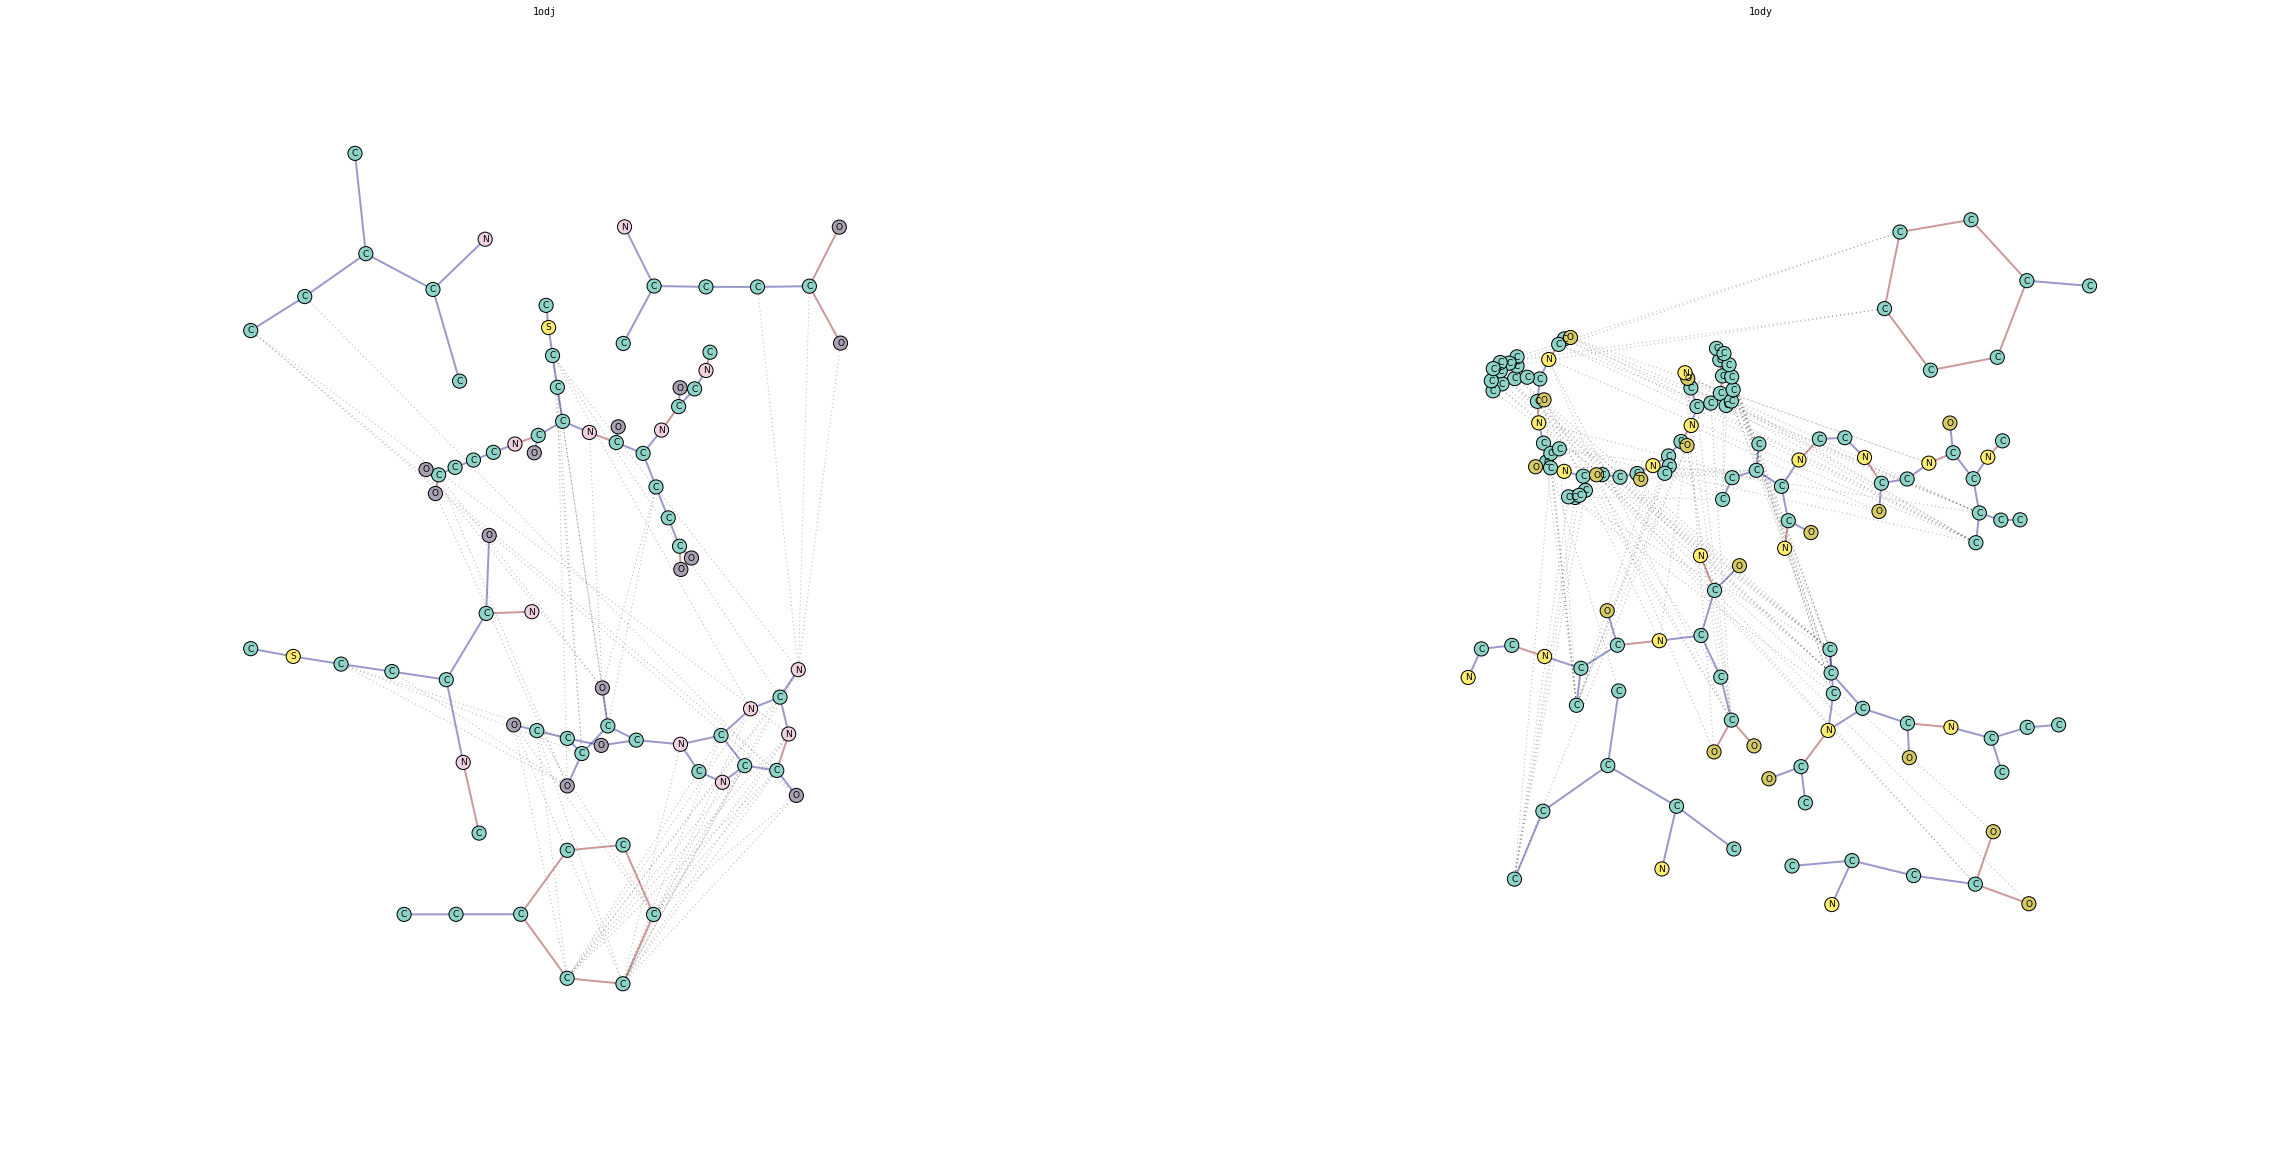

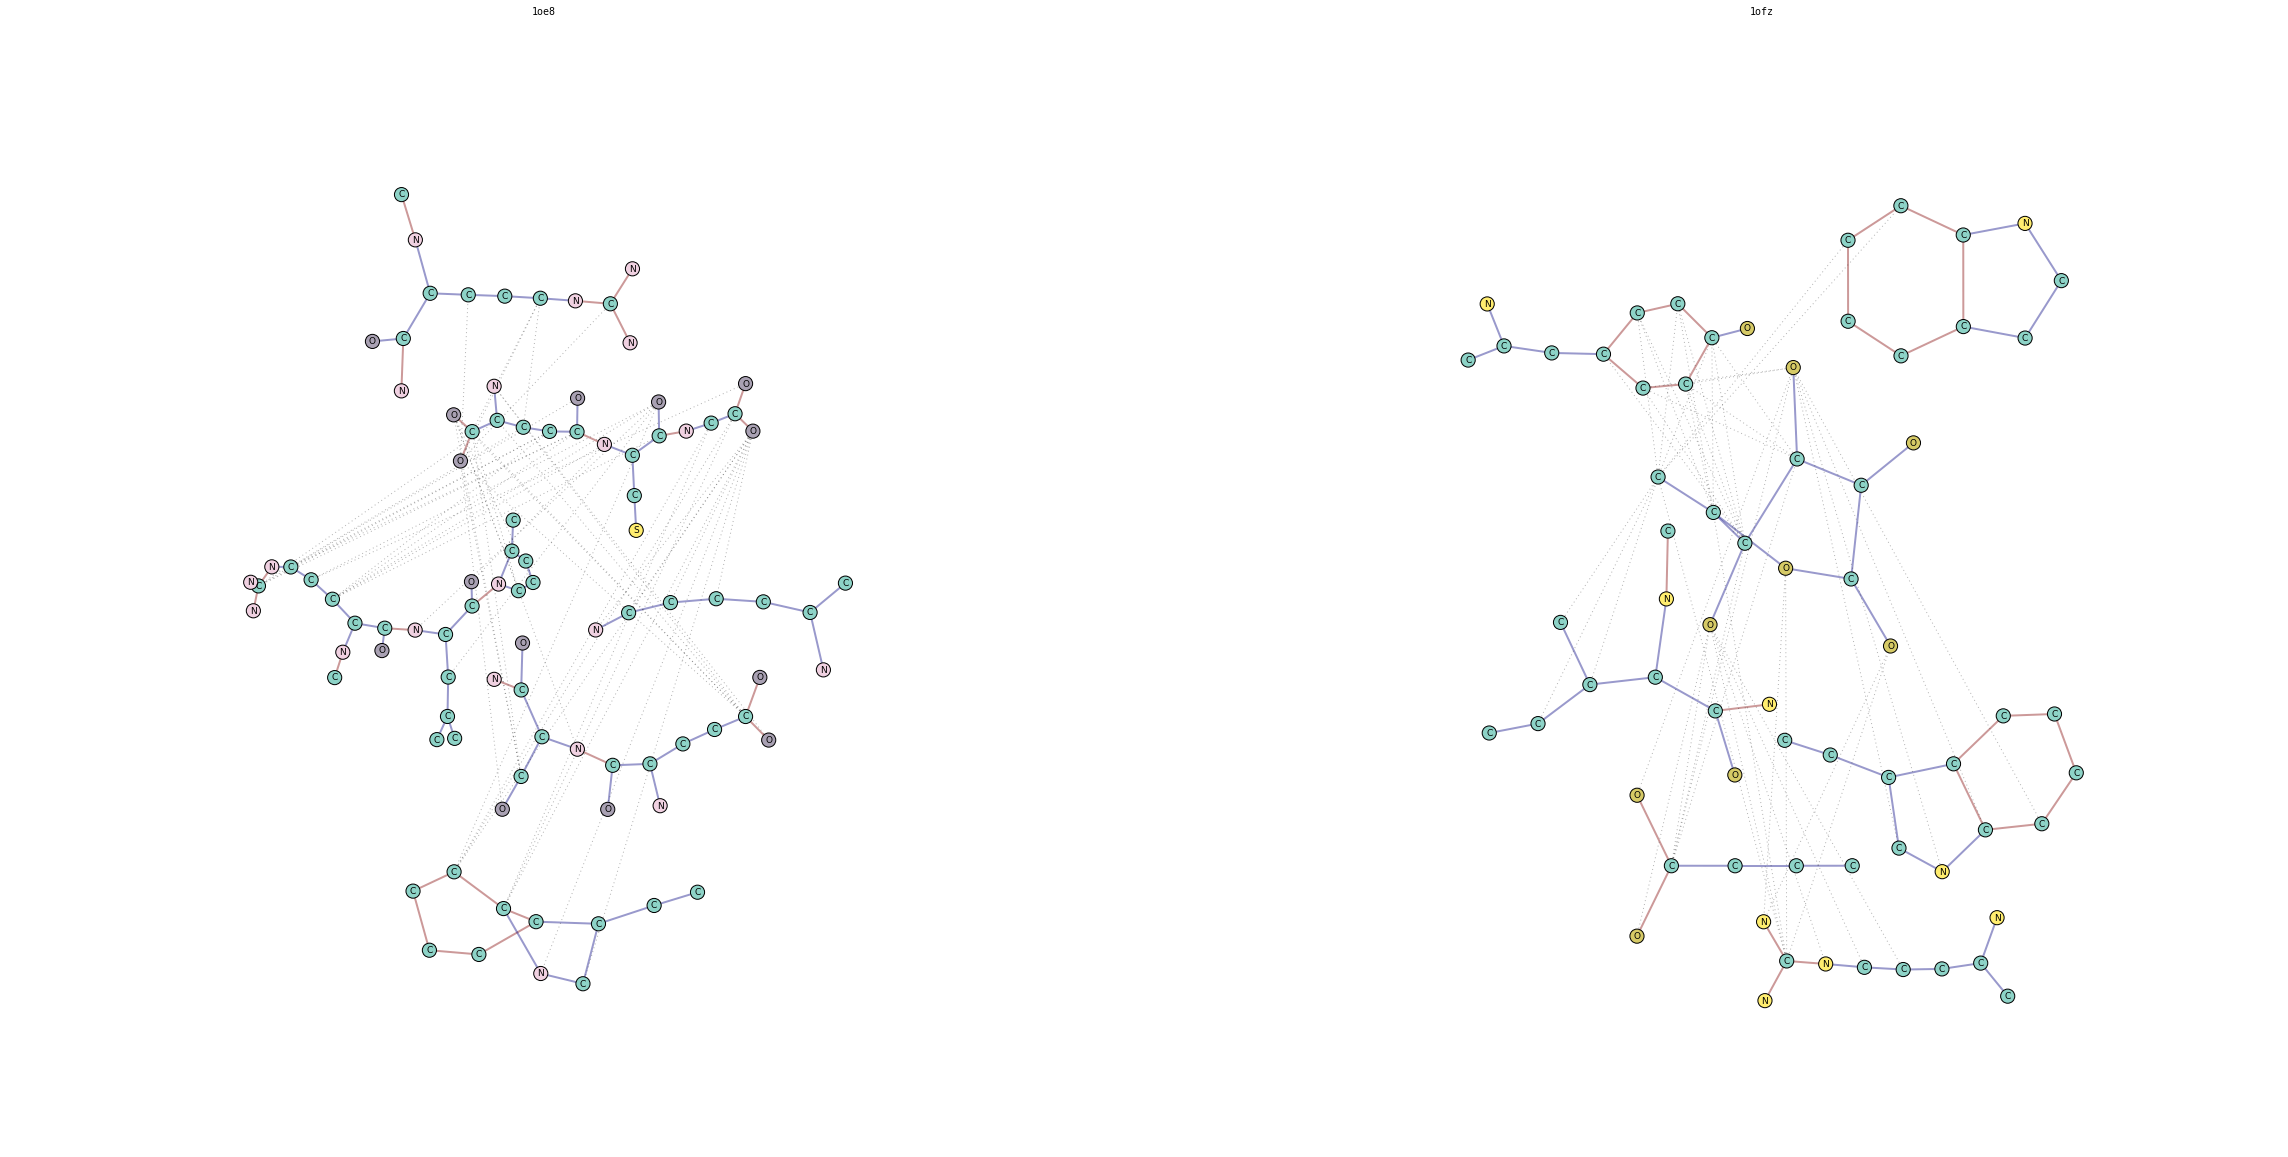

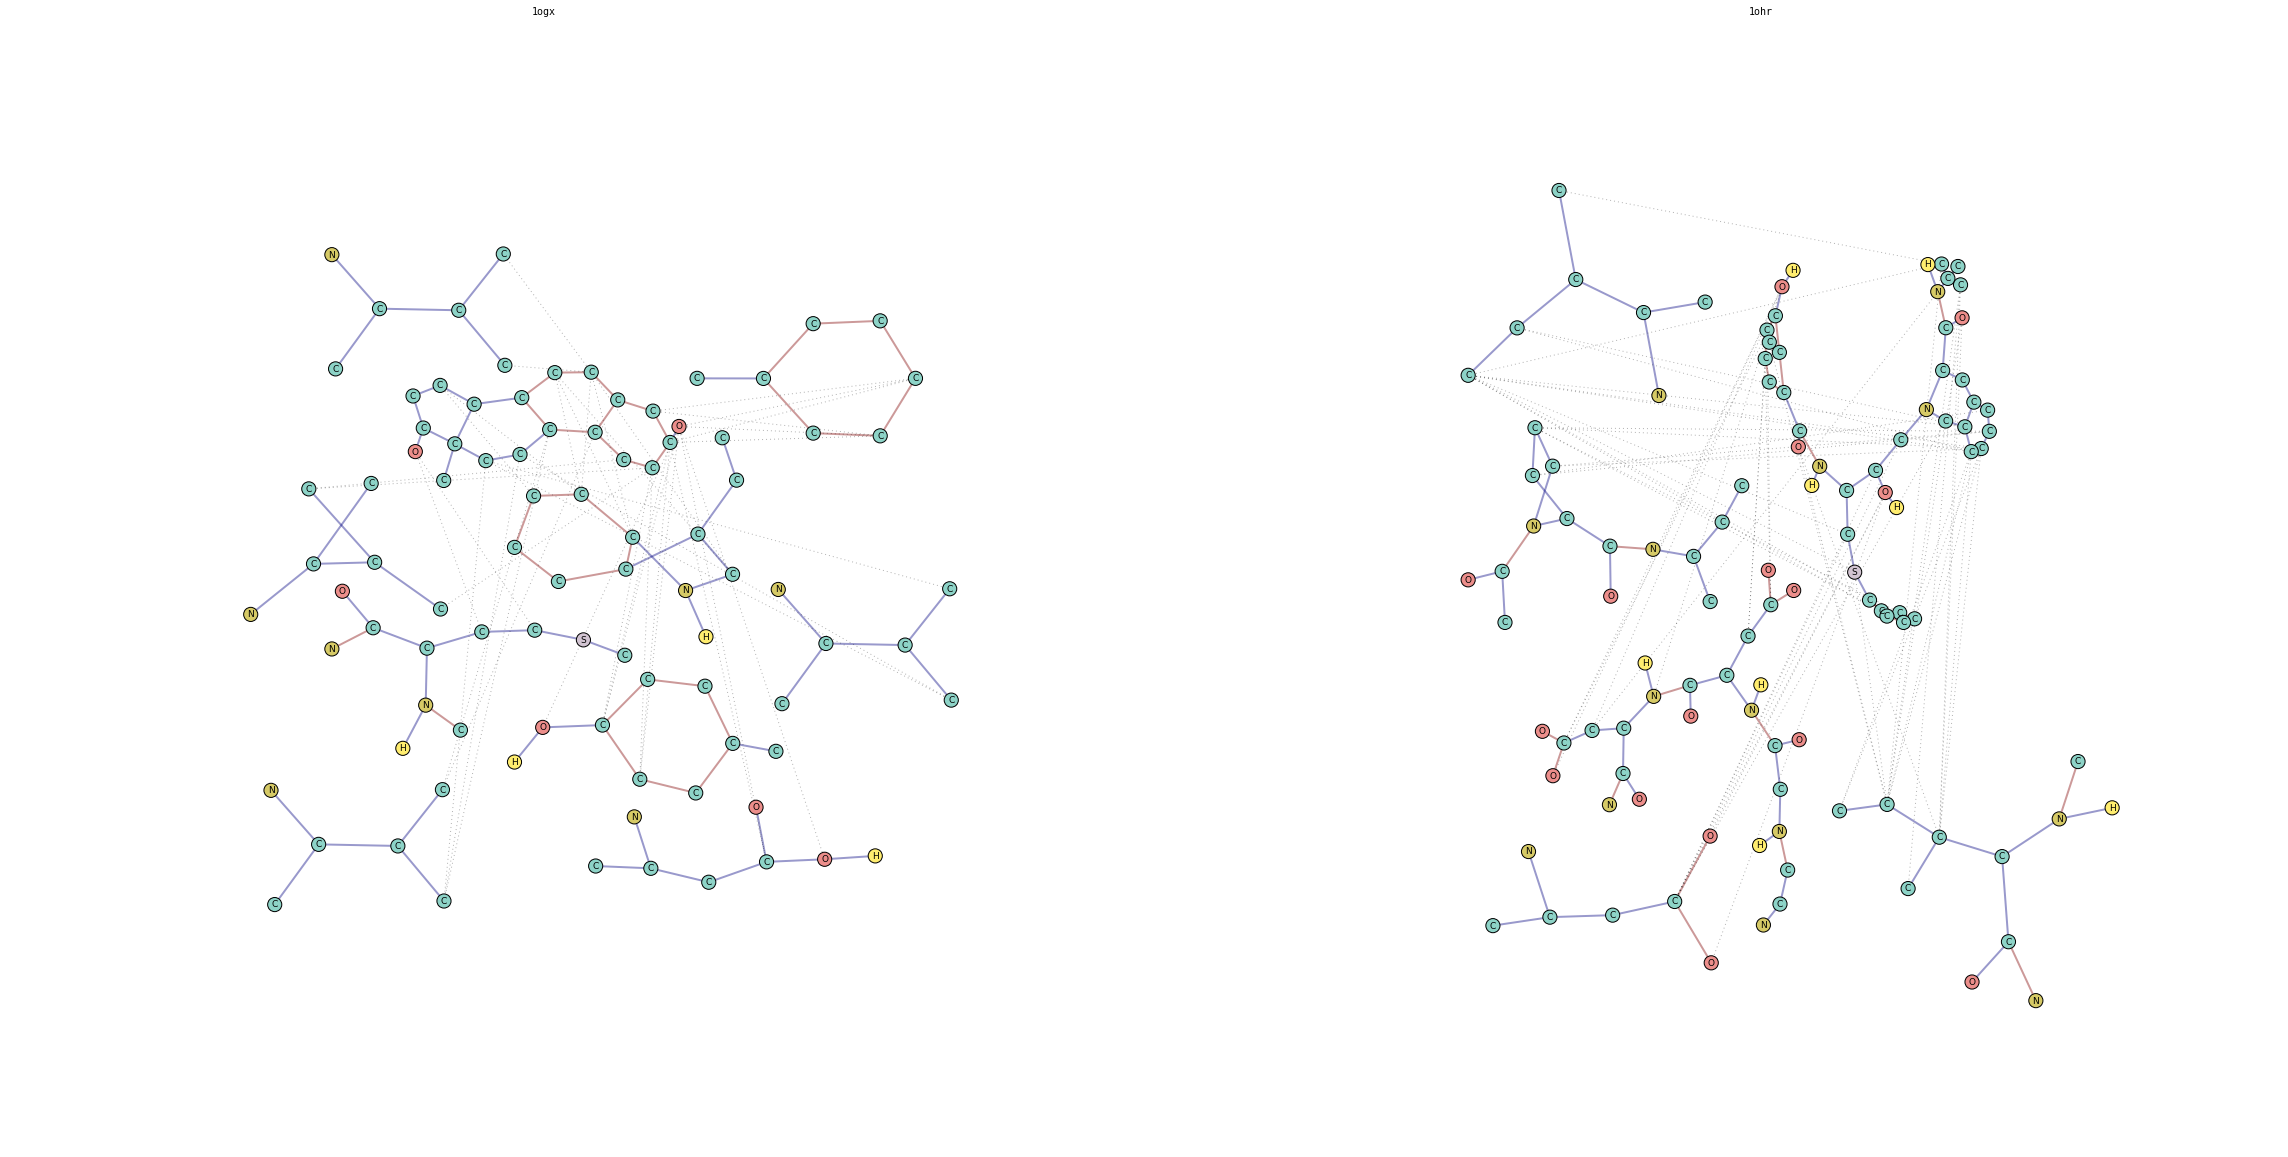

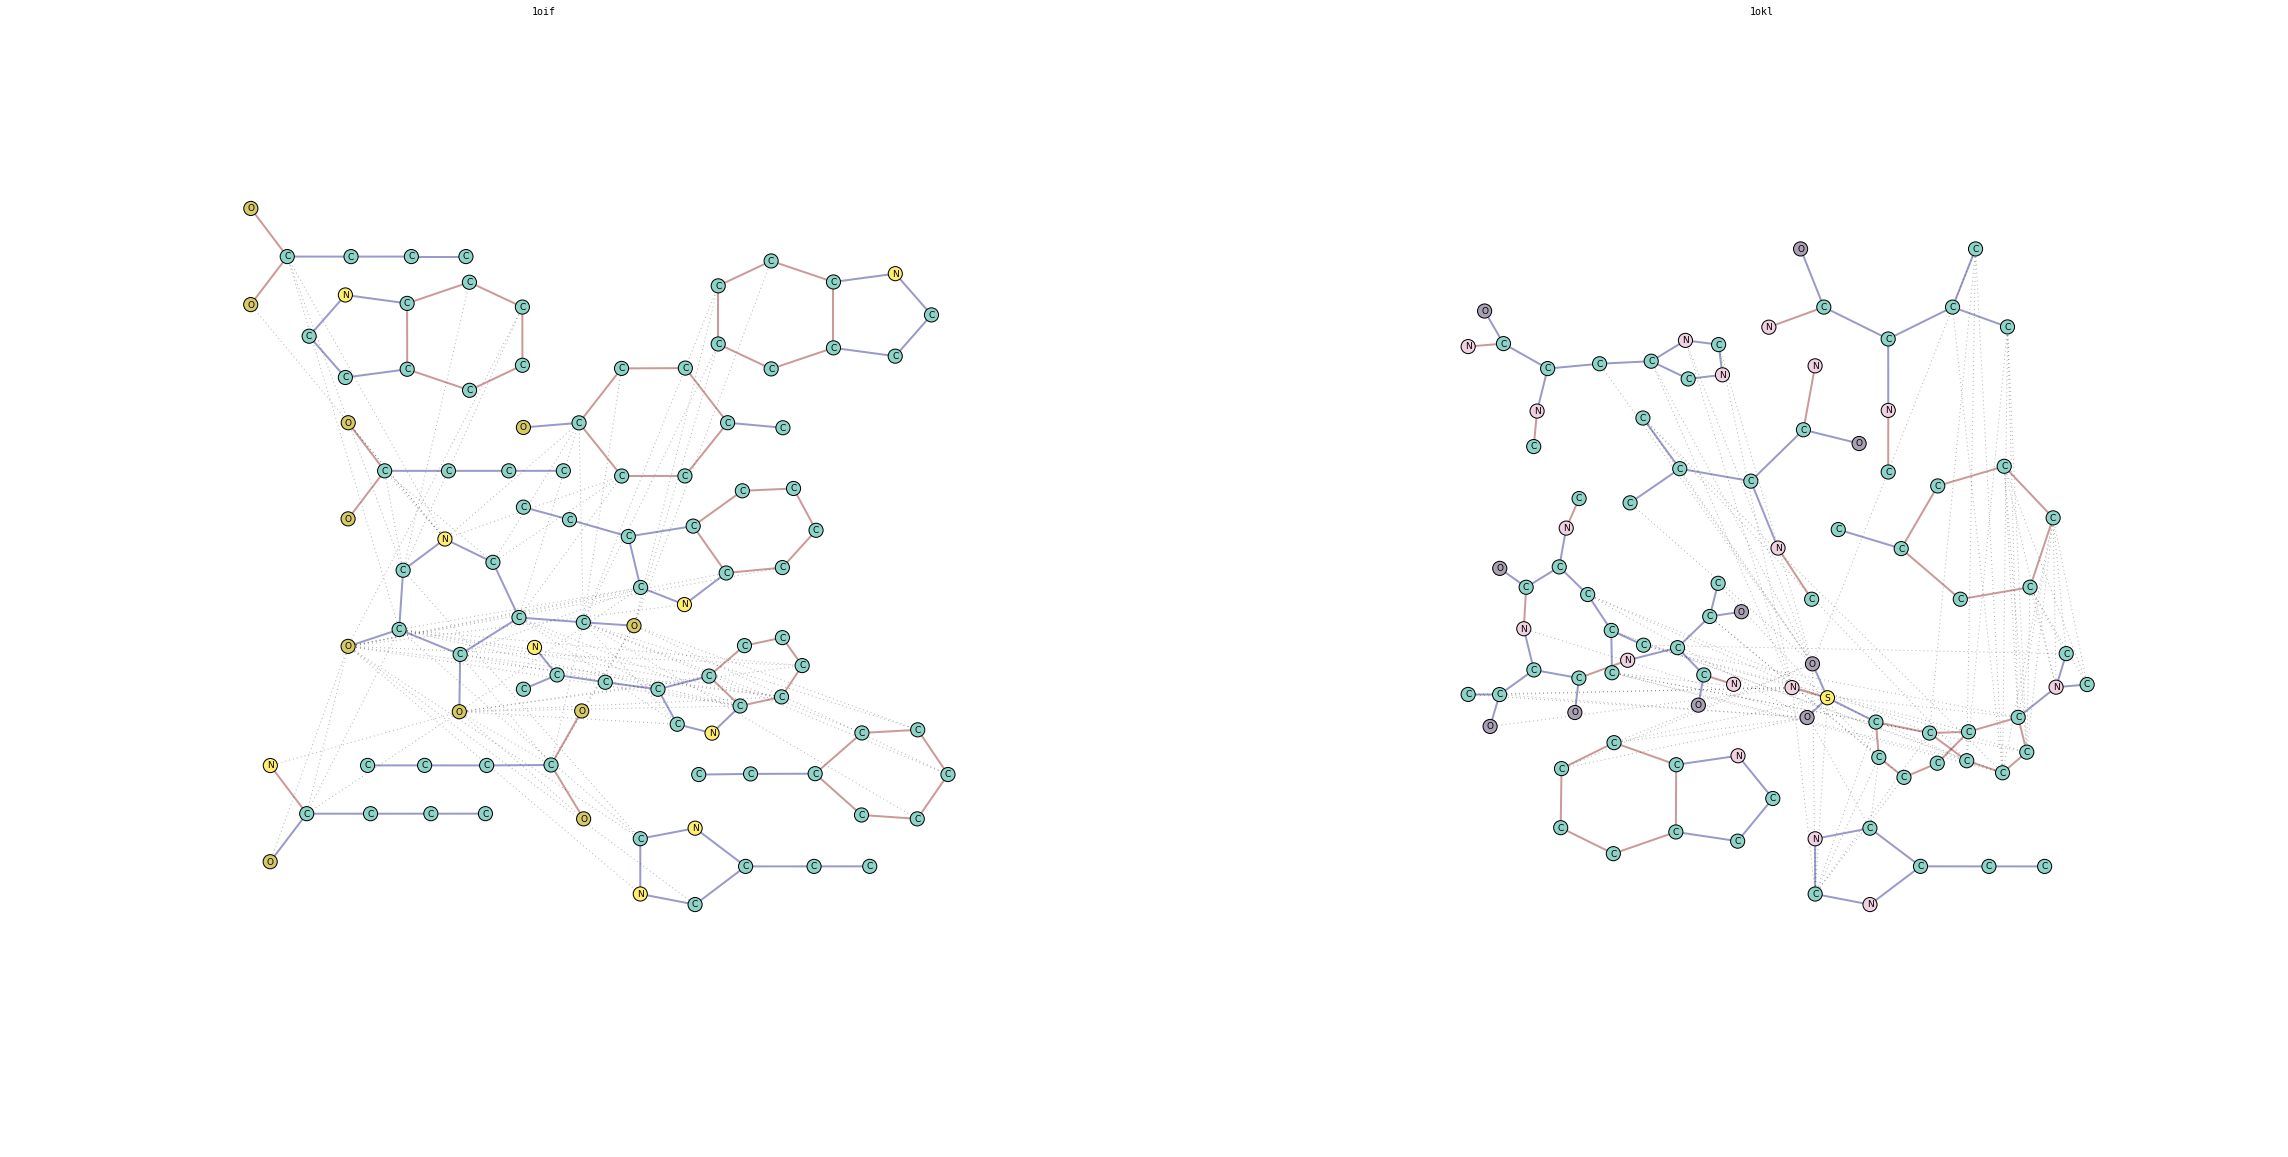

In [26]:
from itertools import islice
from eden.util.display import draw_graph_set
from GArDen.transform.node import ColorNode
parameters_priors = dict(output_attribute='level', labels=[['C','O','N','S','H','Cl','.C','.O','.N','.S','.H','.Cl']])
draw_graphs = transform(islice(graphs,8), program=ColorNode(), parameters_priors=parameters_priors)
draw_graph_set(draw_graphs, n_graphs_per_line=2, size=20, title_key='id', prog='sfdp', node_border=1, node_size=200, colormap='Set3',
               edge_color='_label_',vertex_alpha=1, edge_alpha=.4, vertex_label='label', #secondary_vertex_label='type', 
               vertex_color='level', ignore_for_layout='nesting')

---

# Predictive modeling

In [27]:
# read a target map 
target_fname = 'PDBbind_refined07-core07.txt'
y = make_target(target_fname, graphs)

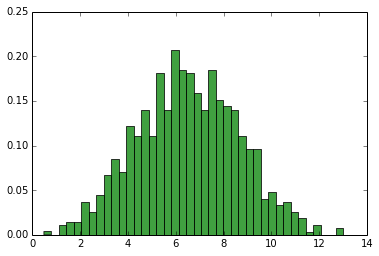

In [28]:
plt.hist(y, 40, normed=1, facecolor='green', alpha=0.75)
plt.show()

In [29]:
%%time
from eden.graph import Vectorizer
from eden.util import vectorize
X = vectorize(graphs, vectorizer=Vectorizer(complexity=2), fit_flag=False, n_jobs=-1)
print 'Instances: %d Features: %d with an avg of %d features per instance' % (X.shape[0], X.shape[1],  X.getnnz()/X.shape[0])

Instances: 866 Features: 1048577 with an avg of 1515 features per instance
CPU times: user 11.2 s, sys: 1.12 s, total: 12.3 s
Wall time: 19.2 s


In [30]:
%%time
import time
#induce a predictive model
from sklearn.svm import SVR
predictor = SVR(C=62.52,gamma=0.279)

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_predict
#predicted = cross_val_predict(predictor, X, y, cv=5, n_jobs=-1)
predicted = cross_val_predict(predictor, X, y, cv=StratifiedKFold(y, n_folds=5, shuffle=True, random_state=int(time.time())), n_jobs=-1)

print 'Corr coeff: %.4f'%(np.corrcoef([predicted,y])[0][1])

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Corr coeff: 0.6521
CPU times: user 248 ms, sys: 181 ms, total: 428 ms
Wall time: 9.26 s


In [19]:
%%time
import time
#induce a predictive model
from sklearn.svm import SVR
predictor = SVR(C=62.52,gamma=0.279)

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_predict
#predicted = cross_val_predict(predictor, X, y, cv=5, n_jobs=-1)
predicted = cross_val_predict(predictor, X, y, cv=StratifiedKFold(y, n_folds=5, shuffle=True, random_state=int(time.time())), n_jobs=-1)

print 'Corr coeff: %.4f'%(np.corrcoef([predicted,y])[0][1])

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Corr coeff: 0.6428
CPU times: user 267 ms, sys: 316 ms, total: 583 ms
Wall time: 7.4 s


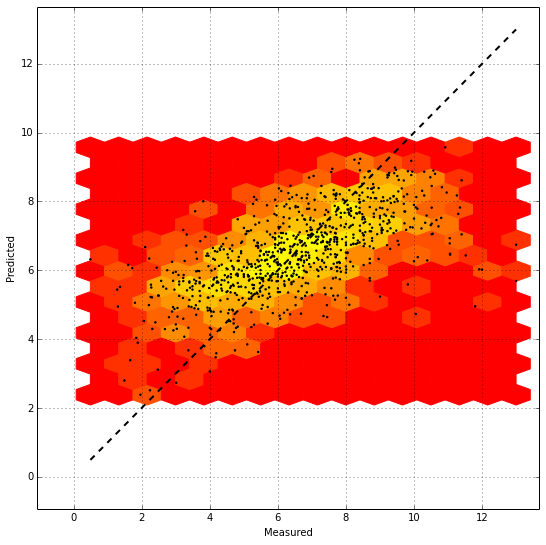

In [20]:
plot(y,predicted)

---

# Range experiment

In [32]:
from GArDen.interfaces import convert, transform
from GArDen.transform.node import AddNodeAttributeValue
from GArDen.transform import DeleteNode
from GArDen.transform.trim_to_largest_component import TrimToLargestComponent
from eden.graph import Vectorizer
from eden.util import vectorize
from sklearn.svm import SVR
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import StratifiedKFold
import time

def run_experiment(data_fname='interaction_data', 
                   target_fname = 'PDBbind_refined07-core07.txt', 
                   max_depth=1, 
                   complexity=5,
                   C=100,
                   gamma=0.1,
                   n_iter=5):    
    graphs = convert(data_fname, program=ConvertProteinLigand())
    parameters_priors = dict(attribute='active', value=False)
    graphs = transform(graphs, program=AddNodeAttributeValue(), parameters_priors=parameters_priors)
    parameters_priors = dict(max_depth=max_depth, attribute='active')
    graphs = transform(graphs, program=MarkActive(), parameters_priors=parameters_priors)
    parameters_priors = dict(attribute_value_dict=[dict(active=False, type='protein')])
    graphs = transform(graphs, program=DeleteNode(), parameters_priors=parameters_priors)
    graphs = transform(graphs, program=TrimToLargestComponent())
    graphs = list(graphs)
    X = vectorize(graphs, vectorizer=Vectorizer(complexity=complexity), fit_flag=False, n_jobs=-1)
    y = make_target(target_fname, graphs)
    
    corr_list=[]
    for i in range(n_iter):
        predictor = SVR(C=C, gamma=gamma)
        predicted = cross_val_predict(predictor, X, y, cv=StratifiedKFold(y, n_folds=5, shuffle=True, random_state=int(time.time())), n_jobs=-1)
        corr = np.corrcoef([predicted,y])[0][1]
        corr_list.append(corr)
    return np.mean(corr_list), np.std(corr_list)

In [ ]:
%%time
import time
import datetime
x1 = []
x2 = []
x3 = []
for max_depth in range(10):
    start = time.time()
    corr_mean, corr_std = run_experiment(data_fname='interaction_data', target_fname = 'PDBbind_refined07-core07.txt', 
                                         max_depth=max_depth,
                                         complexity=2,
                                         C=62.52,
                                         gamma=0.279, 
                                         n_iter=20)
    
    delta_time = datetime.timedelta(seconds=(time.time() - start))
    print 'Max depth: %d   Corr coeff: %.3f +- %.3f   in: %s' % (max_depth, corr_mean, corr_std, str(delta_time))
    x1.append(corr_mean)
    x3.append(corr_std)
    x2.append(max_depth)
x1=np.array(x1)
x2=np.array(x2)
x3=np.array(x3)

Max depth: 0   Corr coeff: 0.649 +- 0.011   in: 0:01:20.988471


In [ ]:
size=7
fig = plt.figure(figsize=(int(2*size), size)) 
plt.fill_between(x2, x1+2*x3, x1-2*x3, facecolor='blue', alpha=0.2)
plt.fill_between(x2, x1+x3, x1-x3, facecolor='blue', alpha=0.2)
plt.plot(x2, x1,  ls='-', lw=2,  marker='o', ms=10, color='k', mew=2, mfc='white')
plt.xlabel('Max depth')
plt.ylabel('Corr coeff')
plt.grid()
plt.xlim(np.min(x2)-.1,np.max(x2)+.1)
plt.show()

In [24]:
%%time
import time
import datetime
x1 = []
x2 = []
x3 = []
for max_depth in range(10):
    start = time.time()
    corr_mean, corr_std = run_experiment(data_fname='interaction_data', target_fname = 'PDBbind_refined07-core07.txt', 
                                         max_depth=max_depth,
                                         complexity=2,
                                         C=62.52,
                                         gamma=0.279, 
                                         n_iter=20)
    
    delta_time = datetime.timedelta(seconds=(time.time() - start))
    print 'Max depth: %d   Corr coeff: %.3f +- %.3f   in: %s' % (max_depth, corr_mean, corr_std, str(delta_time))
    x1.append(corr_mean)
    x3.append(corr_std)
    x2.append(max_depth)
x1=np.array(x1)
x2=np.array(x2)
x3=np.array(x3)

Max depth: 0   Corr coeff: 0.648 +- 0.010   in: 0:12:01.571589
Max depth: 1   Corr coeff: 0.625 +- 0.007   in: 0:02:17.514675
Max depth: 2   Corr coeff: 0.653 +- 0.007   in: 0:02:41.356463
Max depth: 3   Corr coeff: 0.657 +- 0.008   in: 0:02:58.578843
Max depth: 4   Corr coeff: 0.656 +- 0.007   in: 0:03:17.912149
Max depth: 5   Corr coeff: 0.653 +- 0.006   in: 0:03:33.131342
Max depth: 6   Corr coeff: 0.650 +- 0.007   in: 0:03:50.709962
Max depth: 7   Corr coeff: 0.641 +- 0.007   in: 0:04:02.840616
Max depth: 8   Corr coeff: 0.640 +- 0.008   in: 0:04:20.989106
Max depth: 9   Corr coeff: 0.642 +- 0.008   in: 0:04:31.479377
CPU times: user 10min 12s, sys: 47.4 s, total: 11min
Wall time: 43min 36s


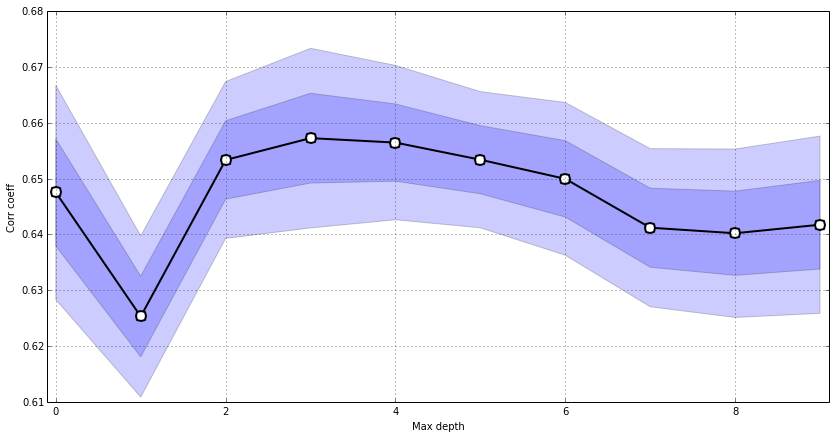

In [32]:
size=7
fig = plt.figure(figsize=(int(2*size), size)) 
plt.fill_between(x2, x1+2*x3, x1-2*x3, facecolor='blue', alpha=0.2)
plt.fill_between(x2, x1+x3, x1-x3, facecolor='blue', alpha=0.2)
plt.plot(x2, x1,  ls='-', lw=2,  marker='o', ms=10, color='k', mew=2, mfc='white')
plt.xlabel('Max depth')
plt.ylabel('Corr coeff')
plt.grid()
plt.xlim(np.min(x2)-.1,np.max(x2)+.1)
plt.show()

---